# News feed classification using LSTM

## Topic

In this notebook I will experiment with sequential data classification using LSTM. My dataset is comprised of news feed with their categories, the news feeds being a long paragraph of news related to a special topic and topics being either sport, entertaimnent, tech, business or politics. I will need to do some pre-processing of the data including TF-IDF vectorization which maps each paragraph to a long vector comprised of the scores of the words within it. Then I will build an LSTM network that can classify the news to their correspondent category. So let's get started ! 

## Obejctives

- Vectorize the news feeds
- Build an LSTM to categorize them

## Summary

- Importing libraries
- The dataset
- Label encoding the target
- Text pre-processing
- Train/Validation/Test splits
- Creating the dataloaders
- Building the network
- Training the network 
- Testing the network
- Inference
- Conclusion

### Importing libraries

In [367]:
import numpy as np
import pandas as pd
from string import punctuation
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
import string
from nltk import word_tokenize
from torch.utils.data import TensorDataset
from scipy.sparse import coo_matrix
import torch.nn.functional as F

### The dataset

In [247]:
data = pd.read_csv(r'C:\Users\imane\Downloads\archive (28)\bbc-text.csv', sep =",")
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


<Axes: >

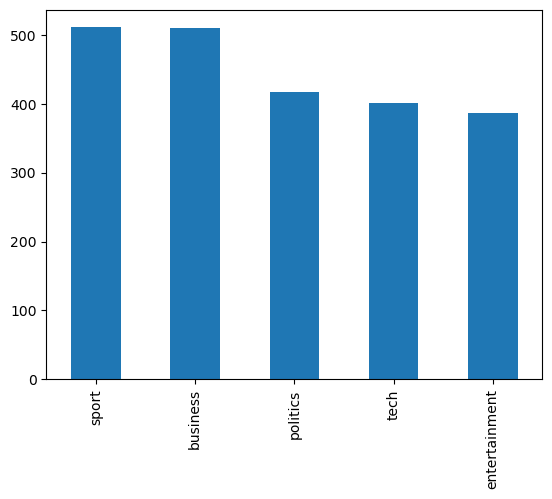

In [249]:
data['category'].value_counts().plot(kind='bar')

So the dataset is csv file that contains news feeds as well as their category, the plot above shows how many of each category there are in the dataset, although there are little difference in the amount of each kind of news I think that the model will work just fine and won't overfit in the favor of  a certain category.

### Label Encoding the target

In [250]:
label_encoder = preprocessing.LabelEncoder() 
data['category']= label_encoder.fit_transform(data['category']) 

<Axes: >

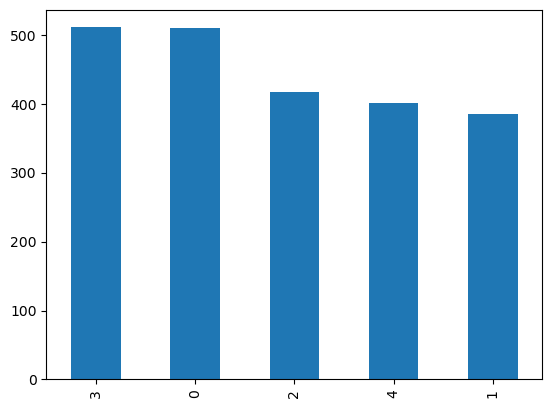

In [251]:
data['category'].value_counts().plot(kind='bar')

In [252]:
target = data["category"]
data = data.drop(columns="category", axis =1)

In [253]:
target.head()

0    4
1    0
2    3
3    3
4    1
Name: category, dtype: int32

### Text pre-processing

In [254]:
data["text"] = data["text"].str.lower()

The first thing I did was to convert the text to lower caracters.

In [255]:
def remove_punct(text):
    text = text.translate(str.maketrans(" "," ", string.punctuation ))
    return text

In [256]:
data["text"] = data["text"].apply(remove_punct)

Then I removed the punctuation.

In [257]:
data.head()

,text
0,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...
2,tigers wary of farrell gamble leicester say ...
3,yeading face newcastle in fa cup premiership s...
4,ocean s twelve raids box office ocean s twelve...


In [261]:
vectorizer = TfidfVectorizer( analyzer='word',stop_words= 'english')

In [262]:
X = vectorizer.fit_transform(data['text'])

In [265]:
print(X.shape)

(2225, 32442)


Next I used TF-IDF vectorizer which maps each utterance of news feed to a vector containing scores for each word depending on the frequency of the presence of the said word in the document. The result has shape 2225 by 32442, the 2225 is the number of news feeds I got while the 32442 represents how long the resulting vectors are.

### Train/Validation/Test splits

In [266]:
X_train, X_test, y_train ,y_test = train_test_split(X, target, random_state = 42, test_size = 0.20)

In [267]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.10)

In [270]:
print(x_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(1602, 32442) (1602,)
(445, 32442) (445,)
(178, 32442) (178,)


I then split my dataset into training, validation and testing sets whose shapes wa can see above. I kept 20% of the training data for test and 10% of the remaining training data for validation.

In [276]:
coo_t = coo_matrix(x_train, dtype= "float32")
coo_v = coo_matrix(x_val, dtype= "float32")
coo_test = coo_matrix(X_test, dtype= "float32")

In [277]:
values = coo_t.data
indices = np.vstack((coo_t.row, coo_t.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_t.shape

train_x = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [278]:
values = coo_v.data
indices = np.vstack((coo_v.row, coo_v.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_v.shape

val_x = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [279]:
values = coo_test.data
indices = np.vstack((coo_test.row, coo_test.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_test.shape

test_x = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

I then used the coo matrix because my resultant features are very big sparse matrices.

In [282]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

### Creating the data loaders

In [283]:
train_data = TensorDataset(train_x, torch.from_numpy(y_train))
val_data = TensorDataset(val_x, torch.from_numpy(y_val))
test_data = TensorDataset(test_x, torch.from_numpy(y_test))

batch_size = 30
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

Then with the help of Tensor Dataset of pytorch I created datasets for training , validation and testing and then created the data loaders with a batch size of 30.

In [296]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([30, 32442])
torch.Size([30])


Next I checked the shapes of my input and label and they seem all good.

### Building the network

In [340]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size,  hidden_dim, n_layers, drop_prob=0.3):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        
        self.lstm = nn.LSTM(vocab_size, hidden_dim, n_layers, batch_first=True, dropout = drop_prob)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x, hidden):
        #batch_size = x.size(0)
        output, hidden = self.lstm(x, hidden)
        output = output.reshape(-1, self.hidden_dim)
        out = self.dropout(output)
        out = self.fc(out)

        return out, hidden
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, self.hidden_dim).zero_())
        return hidden
        

In [341]:
vocab_size = X.shape[1]
output_size = 5
hidden_dim = 356
n_layers = 3
net = LSTM(vocab_size, output_size, hidden_dim, n_layers )
print(net)

LSTM(
  (lstm): LSTM(32442, 356, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=356, out_features=5, bias=True)
)


So I built an LSTM from scratch, it contains 3 layers, 356 hidden dimensions, and its connected to the fully connected layers with 5 as output size. I used dropout with probability of 0.3 and initialized the hidden and cell states. Then I printed the resultant network.

### Training the network

In [342]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

Here I used cross entropy loss because I'm dealing with multiple categories, I sat the learning rate to 0.001 and the optimizer to Adam.

In [343]:
epochs = 20
print_every= 100
count = 0
clip = 5
valid_loss_min = np.Inf
train_accuracy, val_accuracy = [],[]

net.train()
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    h = net.init_hidden()
    for x, y in train_loader:
        count +=1
        h = tuple([each.data for each in h])
        optimizer.zero_grad()
        out, h = net(x, h)
        loss = criterion(out.squeeze(), y.long())
        train_loss += loss.item()
        loss.backward()
        preds = F.log_softmax(out, dim=1)
        ps = torch.exp(preds)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == y.view(*top_class.shape)
        t_acc += equals.sum().item()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        if count % print_every == 0:
            with torch.no_grad():
                net.eval()
                v_acc = 0.0
                val_h = net.init_hidden()
                for x, y in val_loader:
                    val_h = tuple([each.data for each in h])
                    out, h = net(x, h)
                    v_loss = criterion(out.squeeze(), y.long())
                    valid_loss += v_loss.item()
                    preds = F.log_softmax(out, dim=1)
                    ps = torch.exp(preds)
                    top_k, top_class = ps.topk(1, dim=1)
                    equals = top_class == y.view(*top_class.shape)
                    v_acc += equals.sum().item()
                net.train()
            train_loss = train_loss/len(train_loader)
            valid_loss = valid_loss/len(val_loader)
            train_accuracy.append(t_acc/len(train_loader))
            val_accuracy.append(v_acc/len(val_loader))
            
            print("Epoch ", epoch+1, "train loss ", train_loss, "validation loss ", valid_loss)
        
            if valid_loss <= valid_loss_min:
                print("validation loss decreased", valid_loss_min, "---->", valid_loss)
                print("Saving the model")
                torch.save(net.state_dict(), "news_classifier.pt")
                valid_loss_min = valid_loss


Epoch  2 train loss  1.3833259276623995 validation loss  1.3285459280014038
validation loss decreased inf ----> 1.3285459280014038
Saving the model
Epoch  4 train loss  0.11261273674526305 validation loss  0.18969172090291977
validation loss decreased 1.3285459280014038 ----> 0.18969172090291977
Saving the model
Epoch  6 train loss  0.013992395067482063 validation loss  0.24240596890449523
Epoch  8 train loss  0.003127760438353948 validation loss  0.18275687396526336
validation loss decreased 0.18969172090291977 ----> 0.18275687396526336
Saving the model
Epoch  10 train loss  0.0031880053805784796 validation loss  0.2078369714319706
Epoch  12 train loss  0.0005662620972560824 validation loss  0.11529235653579235
validation loss decreased 0.18275687396526336 ----> 0.11529235653579235
Saving the model
Epoch  14 train loss  0.0036487110675189572 validation loss  0.244148438423872
Epoch  16 train loss  0.0001545905845046465 validation loss  0.17758384821936488
Epoch  17 train loss  0.00050

The training happened over 20 epochs, I got my best model around epoch 12 and saved it to my files. During the training I initialized the hidden state, passed the input and hidden state through the network then I used log softmax to get the actual probabilities that the feed corresponds to each class. I kept track of both the training and validation losses and calculated their accuracies.

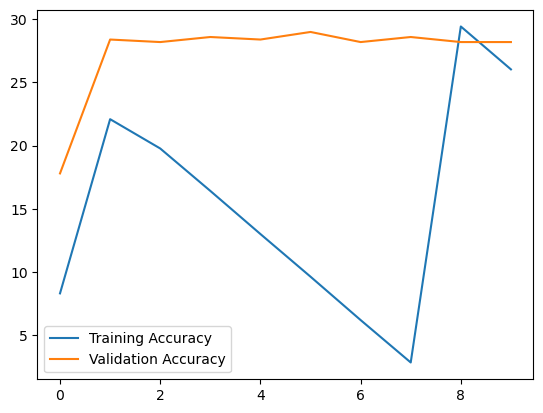

In [344]:
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()

The plot above shows the accuracy of training vs validation, I can see that the training accuracy falls and then spikes to reach the testing accuracy, while the testing accuracy increases steadily and then stays on pretty much the same level.

### Testing the network

In [345]:
classes = ["business",  'entertainment', "politics", "sport", 'tech']

In [368]:
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
h = net.init_hidden()
net.eval()
for inputs, labels in test_loader:

    h = tuple([each.data for each in h])
    output, h = net(inputs, h)

    loss = criterion(output.squeeze(), labels.long())
    test_loss += loss.item()
    p = F.log_softmax(output, dim=1)
    _, pred = torch.max(p, 1)    
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    for i in range(len(labels)):

        label = labels.data[i]
    
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_losses = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))



Test Loss: 3.381683

Test Accuracy of business: 85% (80/94)
Test Accuracy of entertainment: 100% (77/77)
Test Accuracy of politics: 100% (80/80)
Test Accuracy of sport: 100% (93/93)
Test Accuracy of  tech: 90% (69/76)

Test Accuracy (Overall): 95% (399/420)
Test loss: 0.008


During the testing phase, I used the data unseen by the network, I followed the same steps as in the validation process, although this time I calculated how many correct answers does my model get for each class. The results are pleasing seen as the overall accuracy is 95% (it's 100% for some classes), and the mean loss is as low as 0.008.

### Inference

In [366]:
net.eval()
x, y = next(iter(test_loader))
x = x[:4]
y = y[:4]
h = net.init_hidden()
h = tuple([each.data for each in h])
output, h = net(x, h)
p = F.log_softmax(output, dim=1)
_, pred = torch.max(p, 1)
print("Net output ", pred)
print("Actual label ", y)

Net output  tensor([3, 3, 3, 0])
Actual label  tensor([3, 3, 3, 0], dtype=torch.int32)


I used the testing dataset to do some inference, I simply made predictions on a couple of news feeds and compared the results of the network with the actual labels and they match !

## Conclusion

In this notebook I had the opportunity to work with supervised learning to classify news feeds into five categories. I first did a couple of pre-processing techniques on the raw text data, then I built a stacked LSTM and trainined it to recognize the kind of news fed to it. The results I got were great (an overall accuracy of 95%) and a very low error.